# intro

The purpose of this notebook is to look again at the terms for budgeting in the Barents Sea; here we can start from the fully budgeted version of the salt and heat fluxes, then we can try to make the vectors for the adv, df, and heat terms

# packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# read grid and files

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Salt'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'SEAICEheatConsFix': 0,
    'conserveTr': 0,
    'seaice_variable_salinity_flag': 0
}

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


## Get the timesteps

In [11]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2014"] = np.arange(3,5,1)
# times["2014"] = np.arange(9,11,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

In [12]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [13]:
# ocean and ice
AB_gT=0
AB_gS=0

# create the salt budget
### salt tendency

In [14]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

In [15]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean

budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

### salt h conv

In [16]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

In [17]:
# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

In [18]:
# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])

### salt v convergence

In [19]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

In [20]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [21]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux

In [22]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

print(trWtop.shape)
tmp1 = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
tmp1 = tmp1 * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

(50, 1350, 270)


In [23]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

In [24]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [25]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

### show salt is budgeted

In [100]:
# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

pt = np.array([[10,500,4],       # this is organized as x,y,z
               [100,600,10]])

In [120]:
# Data variables (as given in your initial code)
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(1,ny,nx)                 # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s

140313.8434338729
137415.85172566405
5.898964445805177e-07
-3.1633021535526495e-07
-4.0525992517359555e-07
-3.754212229978293e-08
-4.4219348183105467e-07
7.574590199510567e-08
-4.520543370745145e-07
3.8872803997946903e-07
-4.1388011595699936e-07
2.410793058515992e-07
1.5576995338051347e-07
-4.0646864363225177e-07


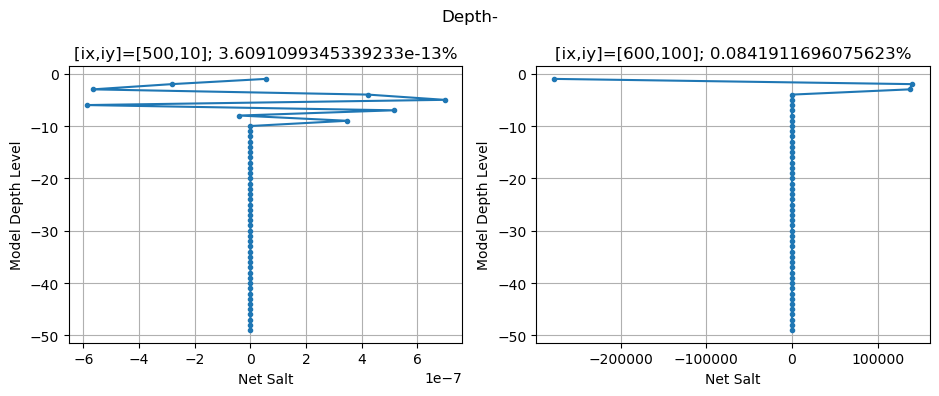

In [124]:
# also show the convergence at depth - I will make this a 1 by 2 plot so I can look at things easier

plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth-")


n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
for i in range(1,15):
    print(a[i, iy, ix]-b[i, iy, ix]- c[i, iy, ix]-d[i, iy, ix])
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[0, n-1] -= zconv_top_salt[iy, ix]

plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['saltfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

# now do the heat budget
### start with the tendency

In [103]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/s

In [104]:
tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

### do h convergence

In [105]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

In [106]:
# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

### do the vertical convergence

In [107]:
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))

In [108]:
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

In [109]:
geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))

In [110]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

In [111]:
budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

2


In [112]:
nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323

if myparms['SaltPlumeHeatFlux']:                                             # not applicable in this example
    tmp1 = mk3D_mod(SPforcT1,oceEPtnd) - np.cumsum(oceEPtnd,axis=0)*RAC3
    trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[1:,:,:]
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

In [113]:
budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

In [114]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

In [115]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

In [116]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this

### Show that this is budgeted

In [117]:
# now we can plot these the same way as we did for salt
# Data variables (as given in your initial code)
a = budgO['heatfluxes']['tend']
b = budgO['heatfluxes']['ADV_Tconv']
c = budgO['heatfluxes']['DF_Tconv']
d = budgO['heatfluxes']['KPP_Tconv']
e = zconv_top_heat.reshape(1,ny,nx)                 # NOTE - this is only at the surface
f = swtop

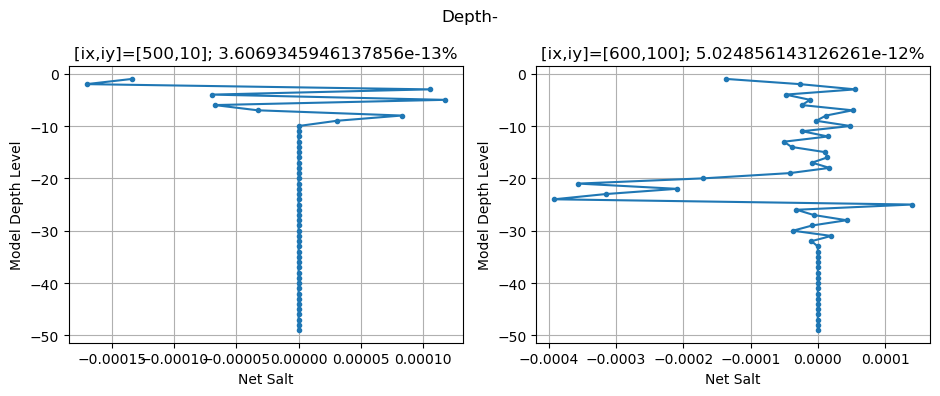

In [118]:
# show the convergence of heat at depth - I will make this a 1 by 2 plot so I can look at things easier
plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth-")

n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = (a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix])
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])    # for swtop we want the difference between the top and bottom
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top_heat[iy, ix]      # subtract the TFLUX at the surface only
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:-1, n-1] += (f[2:,iy,ix] - f[1:-1,iy,ix])
aa[0, n-1] += f[1,iy,ix]
aa[0, n-1] -= zconv_top_heat[iy, ix]                   # this is because we already included the TFLUX
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['heatfluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()

In [95]:
a = budgO['saltfluxes']['tend']
b = budgO['saltfluxes']['ADV_Sconv']
c = budgO['saltfluxes']['DF_Sconv']
d = budgO['saltfluxes']['KPP_Sconv']
e = zconv_top_salt.reshape(1,ny,nx)                 # only at surface, is the surface forcing  ((SFLUX + oceSPflx) * RAC) in g/s

Text(0.5, 1.0, 'salt vector convergence surface')

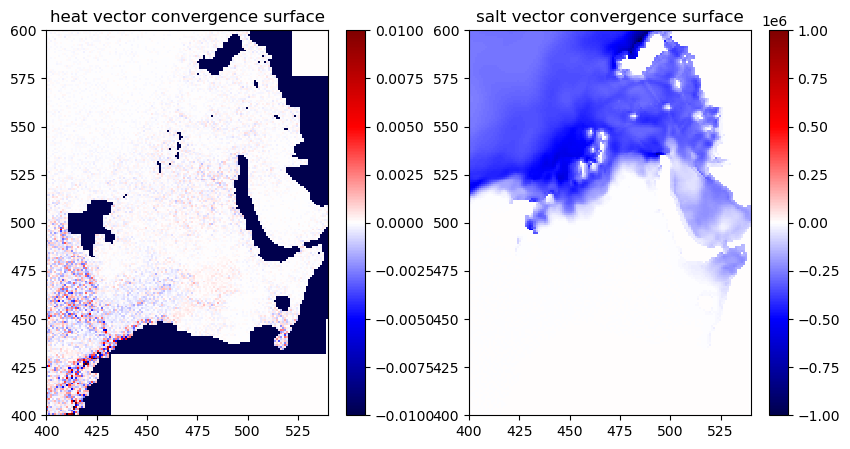

In [99]:
# I feel like I also want to plot this closure in map view in the correct units so I can compare to the figures

# do for surface and compare this to what we see in the transformation plot
fig = plt.figure(figsize = (10,5))

# first subplot -- look at the Ttend - all other terms
ax = plt.subplot(121)
data = budgO['heatfluxes']['tend'][0] - budgO['heatfluxes']['ADV_Tconv'][0] - budgO['heatfluxes']['DF_Tconv'][0] - budgO['heatfluxes']['KPP_Tconv'][0] + swtop[1] -zconv_top_heat
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap='seismic',vmin=-1e-2,vmax=1e-2)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("heat vector convergence surface")


ax = plt.subplot(122)
data = a[0] - b[0] - c[0] - d[0] - e[0]
cb = ax.pcolormesh(get_aste_tracer(data,nfx,nfy)[0],cmap='seismic',vmin=-1e6,vmax=1e6)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("salt vector convergence surface")

In [45]:
ffac = 1e-6

In [46]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [47]:
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

theta = THETA.reshape(nz,ny,nx)
salt = SALT.reshape(nz,ny,nx)

In [48]:
# create the bins of TS data
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)


# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [71]:
maskArc = mskBasin * mymsk

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
# doing some reshaping here so that we can plot more easily
# mesh = create_TS_mesh(tsstr[:-1],nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol,idxs,dT,dS)
# print(mesh.shape)

# if we want to do just the surface of the basin:
surf_vol = vol.copy()
surf_vol[:,1:,:,:] = np.nan
mesh = create_TS_mesh(tsstr[:-1],nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),surf_vol,idxs,dT,dS)

In [72]:
# sum the volume from the points in dimension 2
vol_mesh = np.nansum(mesh[0],axis=2)

In [73]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

/tmp/ipykernel_788413/2525442684.py:12: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)


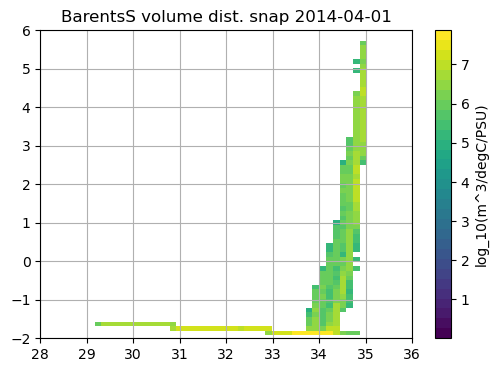

In [74]:
# just plot volume to start ( I am scared I messed something up )
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(6,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .25

ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
# U1, V1 = -G_S_vec_m1,G_T_vec_m1/16
# q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=2e0)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title(strb[iB] + " volume dist. snap " + datetimes[1].strftime("%Y-%m-%d"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,6)
ax1.grid()
# ax1.quiverkey(q1,X=0.1,Y=0.9,U = U,label=str(U) + " Sv")

# Try to calculate the vectors for G

In [75]:
# create the mesh of vectors for GS and GT
def calc_vectors(attr,binned_theta,binned_salinity,nT,nS,binwidthS,binwidthT):
    '''
    Creates the G_S and G_T terms provided either attr, the S tend, or attr, the T tend
    
    Inputs:
        attr: for one time step, the tendency in terms of PSU.m^3/s or degC.m^3/s (shape nz,ny,nx)
        binned_theta,binned_salinity: the indices of the salt and temp bins for each nz,ny,nx point at that tstep
        nT, nS: number of cell centers
        binwidthT, binwidthS: bin widths in T-S space for comparison

    Outputs:
        an array of shape nT, nS of the G term values for a given basin or set of basins
    '''
    # initialize the TS mesh
    distr_attr = np.full((nT,nS),0.0)

    # initialize tiles for binwidths
    binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
    binwidthsT_tile = np.tile(binwidthT, (112, 1))

    # get the indices where not nan that we want to categorize so that we don't have to loop
    indices = np.where(~np.isnan(binned_theta))
    z,y,x = indices[0],indices[1],indices[2]

    # loop over the z,y,x indices, grab the values from attr, and add them to the mesh
    for i,j,k in zip(z,y,x):
        distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr[i,j,k]    # degC.m^3/s OR PSU.m^3/s

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
    #distr_attr  = distr_attr/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/PSU OR m^3/s/degC
    distr_attr *= 1e-6                                                    # Sv/PSU or Sv/degC
    distr_attr[distr_attr == 0 ] = np.nan

    return distr_attr

In [76]:
# volume has already been made into the Barents Sea, we can use these indices or do masking before calc G term

### first create the tendency vectors -- do for surface only

In [77]:
# we need to mask only the Barents Sea when we do this
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

In [79]:
# do the tendency vectors first
Ttend = budgO['heatfluxes']['tend'] / myparms['rcp']            # degC.m^3/s
Stend = budgO['saltfluxes']['tend'] / myparms['rhoconst']       # PSU.m^3/s

# select surface only
Ttend[1:,:,:] = 0
Stend[1:,:,:] = 0

J_T_vec = calc_G_term(Ttend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU
J_S_vec = calc_G_term(Stend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC

In [80]:
# now do the advection vectors from budgO['heatfluxes']['ADV_Tconv'] and budgO['heatfluxes']['ADV_Sconv']
ADV_Ttend = budgO['heatfluxes']['ADV_Tconv'] / myparms['rcp']          # degC.m^3/s
ADV_Stend = budgO['saltfluxes']['ADV_Sconv'] / myparms['rhoconst']     # PSU.m^3/s

# select surface only
ADV_Ttend[1:,:,:] = 0
ADV_Stend[1:,:,:] = 0

ADV_T_vec = calc_G_term(ADV_Ttend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU
ADV_S_vec = calc_G_term(ADV_Stend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC

In [81]:
# do for diffusive terms
# now do the advection vectors from budgO['heatfluxes']['ADV_Tconv'] and budgO['heatfluxes']['ADV_Sconv']
DF_Ttend = budgO['heatfluxes']['DF_Tconv'] / myparms['rcp']          # degC.m^3/s
DF_Stend = budgO['saltfluxes']['DF_Sconv'] / myparms['rhoconst']     # PSU.m^3/s

# select surface only
DF_Ttend[1:,:,:] = 0
DF_Stend[1:,:,:] = 0

DF_T_vec = calc_G_term(DF_Ttend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU
DF_S_vec = calc_G_term(DF_Stend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC

In [82]:
# do kpp terms
# now do the advection vectors from budgO['heatfluxes']['ADV_Tconv'] and budgO['heatfluxes']['ADV_Sconv']
KPP_Ttend = budgO['heatfluxes']['KPP_Tconv'] / myparms['rcp']          # degC.m^3/s
KPP_Stend = budgO['saltfluxes']['KPP_Sconv'] / myparms['rhoconst']     # PSU.m^3/s

# select surface only
KPP_Ttend[1:,:,:] = 0
KPP_Stend[1:,:,:] = 0

KPP_T_vec = calc_G_term(KPP_Ttend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU
KPP_S_vec = calc_G_term(KPP_Stend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC

In [83]:
# also do for surface terms - this may be trickier
# for heat: -swtop at some level, +zconv_top_heat
surf_Ttend = np.zeros((nz,ny,nx))
surf_Ttend[0] += zconv_top_heat
surf_Ttend[0] -= swtop[1,:,:]                            # this is the reverse of what we did before bc sw is up
surf_Ttend[1:-1] += (swtop[2:,:,:] - swtop[1:-1,:,:])    # for swtop we want the difference between the top and bottom
surf_Ttend /= myparms['rcp']                             # degC.m^3/s

# for salt: +zconv_top_salt
surf_Stend = np.zeros((nz,ny,nx))
surf_Stend[0] += zconv_top_salt
surf_Stend /= myparms['rhoconst']                        # PSU.m^3/s

# select surface only
surf_Ttend[1:,:,:] = 0
surf_Stend[1:,:,:] = 0

surf_T_vec = calc_G_term(surf_Ttend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU
surf_S_vec = calc_G_term(surf_Stend*mymsk3d,binned_theta*mymsk3d,binned_salinity*mymsk3d,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/degC

### now plot the terms

/tmp/ipykernel_788413/2105746511.py:12: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2105746511.py:25: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2105746511.py:38: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2105746511.py:51: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2105746511.py:64: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2105746511.py:77: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cma

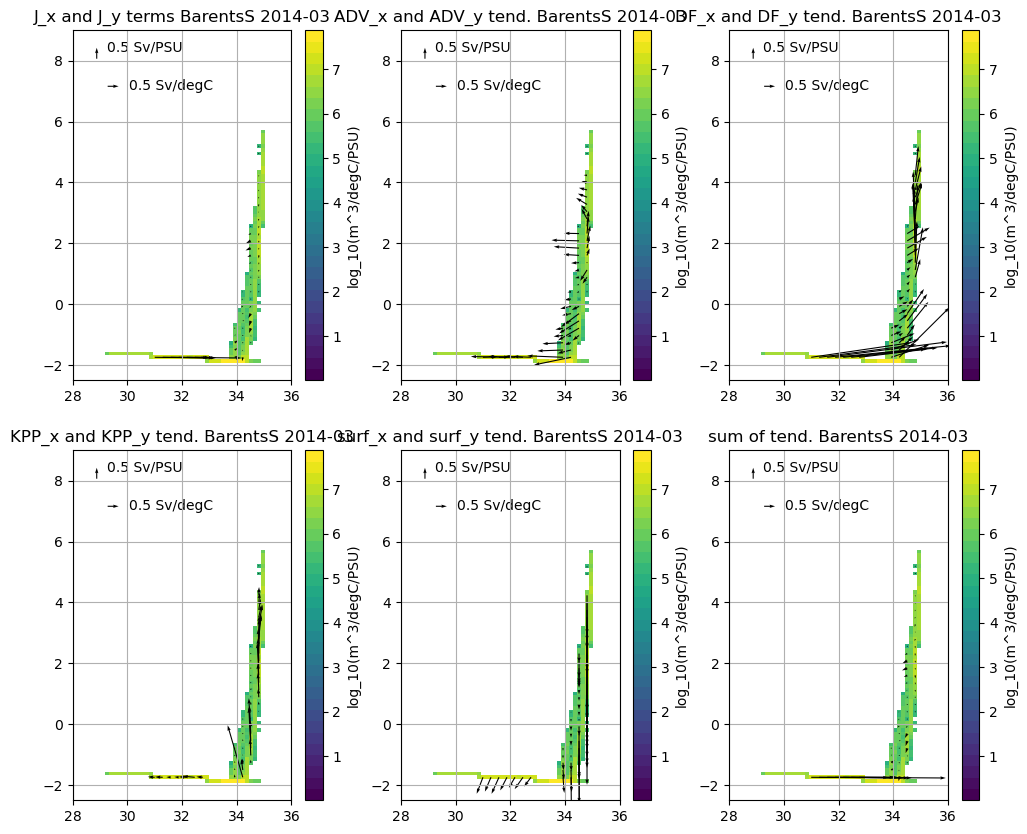

In [84]:
fig = plt.figure(figsize = (12,10))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .5
scale=1e1

# plot total tendencies
ax1 = plt.subplot(231)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1, V1 = J_S_vec,J_T_vec/6
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("J_x and J_y terms " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,9)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# plot advective tendencies
ax1 = plt.subplot(232)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1, V1 = ADV_S_vec,ADV_T_vec/6
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("ADV_x and ADV_y tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,9)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# plot diffusive tendencies
ax1 = plt.subplot(233)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1, V1 = DF_S_vec,DF_T_vec/6
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("DF_x and DF_y tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,9)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# plot KPP tendencies
ax1 = plt.subplot(234)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1, V1 = KPP_S_vec,KPP_T_vec/6
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("KPP_x and KPP_y tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,9)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# plot surface tendencies
ax1 = plt.subplot(235)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1, V1 = surf_S_vec,surf_T_vec/6
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("surf_x and surf_y tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,9)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# do the sum of these
ax1 = plt.subplot(236)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1 = np.nan_to_num(ADV_S_vec) + np.nan_to_num(DF_S_vec) + np.nan_to_num(KPP_S_vec) + np.nan_to_num(surf_S_vec)
U1[U1 == 0] = np.nan
V1 = (np.nan_to_num(ADV_T_vec) + np.nan_to_num(DF_T_vec) + np.nan_to_num(KPP_T_vec) + np.nan_to_num(surf_T_vec))/6
V1[V1 == 0] = np.nan
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("sum of tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,9)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# plt.savefig(path + "sample_totalvectors_Sept2014.png",dpi=300)

/tmp/ipykernel_788413/3459689596.py:14: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/3459689596.py:27: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/3459689596.py:43: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)


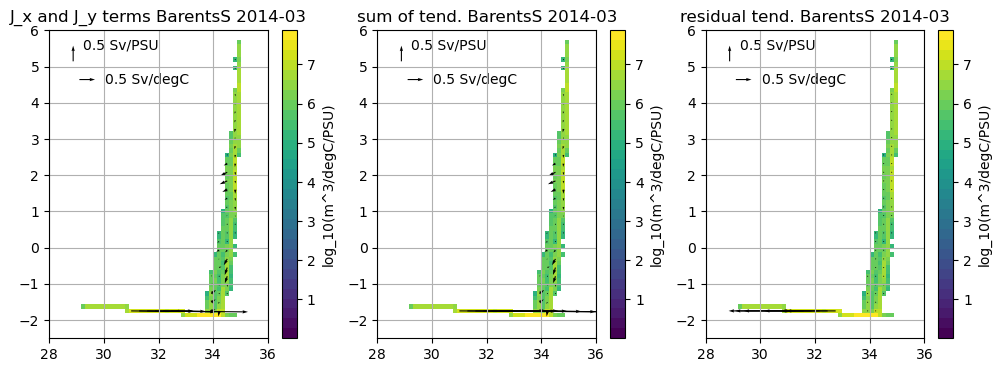

In [85]:
# also look at the difference between the total tend and the sum of tendencies

fig = plt.figure(figsize = (12,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .5
scale=7e0

# plot total tendencies
ax1 = plt.subplot(131)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1, V1 = J_S_vec,J_T_vec/6
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("J_x and J_y terms " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# do the sum of these
ax1 = plt.subplot(132)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_sum = np.nan_to_num(ADV_S_vec) + np.nan_to_num(DF_S_vec) + np.nan_to_num(KPP_S_vec) + np.nan_to_num(surf_S_vec)
U1_sum[U1_sum == 0] = np.nan
V1_sum = (np.nan_to_num(ADV_T_vec) + np.nan_to_num(DF_T_vec) + np.nan_to_num(KPP_T_vec) + np.nan_to_num(surf_T_vec))/6
V1_sum[V1_sum == 0] = np.nan
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_sum[::step,::step], V1_sum[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("sum of tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# where is the residual
ax1 = plt.subplot(133)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_resid, V1_resid = (U1 - U1_sum),(V1 - V1_sum)
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_resid[::step,::step], V1_resid[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("residual tend. " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# plt.savefig(path + "sample_totalvectors_diffMarch2014.png",dpi=300)

### we should also look at the map view for verification

In [ ]:
# first tendency in salt and theta
fig = plt.figure(figsize=(8,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(Ttend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb, label = "degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("T tend")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(Stend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb,label = "PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("S tend")

plt.suptitle("Surface tendencies, [].m^3/s")

In [ ]:
# first tendency in salt and theta
fig = plt.figure(figsize=(8,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(ADV_Ttend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb, label = "degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("T tend")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(ADV_Stend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb,label = "PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("S tend")

plt.suptitle("Surface adv tendencies, [].m^3/s")

In [ ]:
# diffusive tendencies in salt and theta
fig = plt.figure(figsize=(8,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(DF_Ttend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb, label = "degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("T tend")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(DF_Stend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb,label = "PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("S tend")

plt.suptitle("Surface df tendencies, [].m^3/s")

In [ ]:
# diffusive tendencies in salt and theta
fig = plt.figure(figsize=(8,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(KPP_Ttend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb, label = "degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("T tend")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(KPP_Stend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb,label = "PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("S tend")

plt.suptitle("Surface kpp tendencies, [].m^3/s")

In [ ]:
# diffusive tendencies in salt and theta
fig = plt.figure(figsize=(8,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(surf_Ttend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb, label = "degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("T tend")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(surf_Stend* mymsk[np.newaxis,:,:],nfx,nfy)[0],cmap='seismic',vmin=-2e3,vmax=2e3)
plt.colorbar(cb,label = "PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("S tend")

plt.suptitle("Surface tendencies (at k = 0), [].m^3/s")

# this last version of the March BarentsSea looks almost correct, let's check this with other terms

/tmp/ipykernel_788413/2842244680.py:19: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2842244680.py:41: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2842244680.py:60: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2842244680.py:79: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
/tmp/ipykernel_788413/2842244680.py:98: RuntimeWarning: divide by zero encountered in log10
  cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)


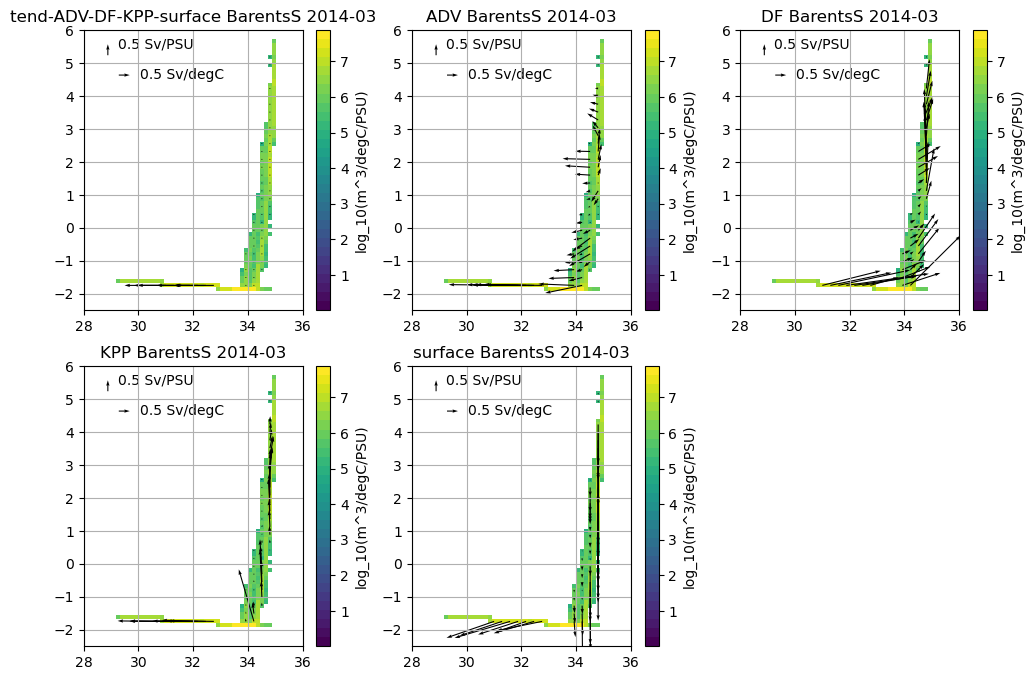

In [86]:
# setup the figure
fig = plt.figure(figsize = (12,8))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = 0
U = .5
scale=1e1
U1, V1 = J_S_vec,J_T_vec/6   # set up the tendency
U1_sum = np.nan_to_num(ADV_S_vec) + np.nan_to_num(DF_S_vec) + np.nan_to_num(KPP_S_vec) + np.nan_to_num(surf_S_vec)
U1_sum[U1_sum == 0] = np.nan
V1_sum = (np.nan_to_num(ADV_T_vec) + np.nan_to_num(DF_T_vec) + np.nan_to_num(KPP_T_vec) + np.nan_to_num(surf_T_vec))/6
V1_sum[V1_sum == 0] = np.nan


# start to plot totally the transformation
ax1 = plt.subplot(231)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_resid, V1_resid = (U1 - U1_sum),(V1 - V1_sum)
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_resid[::step,::step], V1_resid[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("tend-ADV-DF-KPP-surface " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

# try to look at the advective contribution to this
# I think this will be 
U1_sum = (np.nan_to_num(DF_S_vec) + np.nan_to_num(KPP_S_vec) + np.nan_to_num(surf_S_vec))
U1_sum[U1_sum == 0] = np.nan
V1_sum = (np.nan_to_num(DF_T_vec) + np.nan_to_num(KPP_T_vec) + np.nan_to_num(surf_T_vec))/6
V1_sum[V1_sum == 0] = np.nan

# U1_adv,V1_adv = (U1_resid + np.nan_to_num(ADV_S_vec)),(V1_resid + np.nan_to_num(ADV_T_vec))
U1_adv,V1_adv = (U1 - U1_sum),(V1-V1_sum)

ax1 = plt.subplot(232)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_resid, V1_resid = (U1 - U1_sum),(V1 - V1_sum)
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_adv[::step,::step], V1_adv[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("ADV " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# try to look at the diffusive contribution to this
U1_sum = (np.nan_to_num(ADV_S_vec) + np.nan_to_num(KPP_S_vec) + np.nan_to_num(surf_S_vec))
U1_sum[U1_sum == 0] = np.nan
V1_sum = (np.nan_to_num(ADV_T_vec) + np.nan_to_num(KPP_T_vec) + np.nan_to_num(surf_T_vec))/6
V1_sum[V1_sum == 0] = np.nan

ax1 = plt.subplot(233)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_resid, V1_resid = (U1 - U1_sum),(V1 - V1_sum)
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_resid[::step,::step], V1_resid[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("DF " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# kpp contribution to total transformation
U1_sum = (np.nan_to_num(ADV_S_vec) + np.nan_to_num(DF_S_vec) + np.nan_to_num(surf_S_vec))
U1_sum[U1_sum == 0] = np.nan
V1_sum = (np.nan_to_num(ADV_T_vec) + np.nan_to_num(DF_T_vec) + np.nan_to_num(surf_T_vec))/6
V1_sum[V1_sum == 0] = np.nan

ax1 = plt.subplot(234)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_resid, V1_resid = (U1 - U1_sum),(V1 - V1_sum)
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_resid[::step,::step], V1_resid[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("KPP " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# surface contribution to total transformation
U1_sum = (np.nan_to_num(ADV_S_vec) + np.nan_to_num(DF_S_vec) + np.nan_to_num(KPP_S_vec))
U1_sum[U1_sum == 0] = np.nan
V1_sum = (np.nan_to_num(ADV_T_vec) + np.nan_to_num(DF_T_vec) + np.nan_to_num(KPP_T_vec))/6
V1_sum[V1_sum == 0] = np.nan

ax1 = plt.subplot(235)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01)
U1_resid, V1_resid = (U1 - U1_sum),(V1 - V1_sum)
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1_resid[::step,::step], V1_resid[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("surface " + strb[iB] + " " + datetimes[t].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2.5,6)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# plt.savefig(path + "AllBarents_March2014_total_v2.png",dpi=300)